### Analysis of U.S. Dept of Labour, Occupation Safety and Health Administration (OSHA) Reports
##### Objective: Perform text mining on accident reports to determine:
1. What are the major types of accidents reflected in the reports?
    * Identify accident types
2. Which type of accidents has the largest number of occurrences?
    * Count of freq for accident types
3. Which part of the human body is injured most? 
    * Identify bodily parts among text
4. What are the more risky occupations involved in such accidents?
    * To extract concept of occupation

In [1]:
# import packages
import os
import pandas as pd
import string

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

### Step 1: Data Preparation

In [2]:
# load accident report dataset
cwd = os.getcwd()
os.chdir(cwd)
df = pd.read_csv("osha.txt", sep='\t', header=None)
df.shape

(10000, 3)

In [3]:
# rename columns
df = df.rename(columns={0: "id", 1: "title", 2: "text"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   title   10000 non-null  object
 2   text    10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [4]:
# word count
df['title_count'] = df['title'].str.split().str.len()
print("Number of words in title and count of titles:\n",\
      df['title_count'].value_counts().sort_values(ascending=False))

df['text_count'] = df['text'].str.split().str.len()
print("Number of words in shortest report: ",min(df['text_count']))
print("Number of words in longest report: ",max(df['text_count']))

Number of words in title and count of titles:
 7     2481
8     2388
9     1579
6     1516
5      657
10     503
2      390
4      239
11      99
1       85
3       54
12       8
13       1
Name: title_count, dtype: int64
Number of words in shortest report:  3
Number of words in longest report:  730


In [5]:
# check number of tokens for longest report
text = df['text'].tolist()
text_token = [word_tokenize(t) for t in text]
print("Number of tokens in longest report: ", len(max(text_token)))

Number of tokens in longest report:  722


In [6]:
# looking at the three word reports
three_word_text = df[df['text_count']==3]
print(three_word_text['text'])

15      InspectionOpen DateSICEstablishment Name
34      InspectionOpen DateSICEstablishment Name
61      InspectionOpen DateSICEstablishment Name
187     InspectionOpen DateSICEstablishment Name
246     InspectionOpen DateSICEstablishment Name
                          ...                   
9892    InspectionOpen DateSICEstablishment Name
9895    InspectionOpen DateSICEstablishment Name
9919    InspectionOpen DateSICEstablishment Name
9933    InspectionOpen DateSICEstablishment Name
9969    InspectionOpen DateSICEstablishment Name
Name: text, Length: 217, dtype: object


In [7]:
# pre-processing
stopword = stopwords.words('english')
#snowball = SnowballStemmer('english')
lemma = nltk.WordNetLemmatizer()

def preproc(tt):
    token = nltk.word_tokenize(tt.lower())
    token = [lemma.lemmatize(t) for t in token]
    token = [t for t in token if t not in stopword]
    token = [t for t in token if t not in string.punctuation+"'"""]
    #token = [t for t in token if not t.isnumeric()]
    #token = [snowball.stem(t) for t in token]
    return token

In [8]:
# preproc title col
title = df['title'].tolist()
title_clean = [preproc(t) for t in title]
title_num = [len(t) for t in title_clean]
title_fd = FreqDist(title_num)
title_flat = [t for tt in title_clean for t in tt]
title_flat_fd = FreqDist(title_flat)
print(title_flat_fd.most_common(20))

[('employee', 7834), ('killed', 2066), ('fall', 1660), ('injured', 1496), ('struck', 1151), ('dy', 984), ("'s", 963), ('worker', 829), ('finger', 810), ('fracture', 645), ('burned', 574), ('crushed', 490), ('shock', 483), ('caught', 475), ('electric', 474), ('falling', 454), ('amputated', 421), ('machine', 405), ('suffers', 400), ('burn', 399)]


In [9]:
# preproc text col
text = df['text'].tolist()
text_clean = [preproc(t) for t in text]
text_num = [len(t) for t in text_clean]
text_fd = FreqDist(text_num)
text_flat = [t for tt in text_clean for t in tt]
text_flat_fd = FreqDist(text_flat)
print(text_flat_fd.most_common(20))

[('wa', 40175), ('employee', 38347), ('1', 28821), ('approximately', 6070), ("'s", 4240), ('working', 3639), ('hospitalized', 3365), ('coworker', 3354), ('truck', 3135), ('2', 3112), ('hospital', 3065), ('left', 2891), ('hand', 2828), ('fell', 2747), ('right', 2657), ('machine', 2622), ('foot', 2568), ('two', 2533), ('line', 2368), ('injury', 2343)]


### Step 2: K-Means Clustering to identify themes
* A clustering approach can be carried out to see if the text reports can be distinguished into different themes

In [10]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.preprocessing import Normalizer
#from sklearn.decomposition import TruncatedSVD
#from sklearn.pipeline import make_pipeline

From the most common words in title and text, add additional stopwords to reduce noise. 

In [11]:
# preprocess in format for tfidf
stopword = stopwords.words('english')+['employee','worker','wa','working','coworker','operator',\
                                       'approximately','a.m.','p.m.','employer','medical',\
                                      'hospital','hospitalized','center']
#snowball = SnowballStemmer('english')
lemma = nltk.WordNetLemmatizer()

def preproc2(tt):
    token = nltk.word_tokenize(tt.lower())
    token = [lemma.lemmatize(t) for t in token]
    token = [t for t in token if t not in stopword]
    token = [t for t in token if t not in string.punctuation+"'"""]
    #token = [t for t in token if not t.isnumeric()]
    #token = [snowball.stem(t) for t in token]
    token = " ".join(token)
    return token

In [12]:
# Create tfidf matrix on report text
text2 = df['text']
text_clean2 = text2.apply(preproc2)
vectorizer = TfidfVectorizer(max_df=0.7, max_features=2500,
                             min_df=3, stop_words=stopword,
                             use_idf=True)
text_features = vectorizer.fit_transform(text_clean2)
text_features.shape

(10000, 2500)

In [13]:
# apply K-means method
from sklearn.cluster import KMeans
from sklearn import metrics

# find optimal K based on silhouette score
lst = []
for i in range(2,10):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=2000, random_state=5)
    km.fit(text_features)
    lst.append([i, metrics.silhouette_score(text_features, km.labels_)])
    
cols = ['clusters', 'silhouette_score']
km_df = pd.DataFrame(lst, columns=cols)
print(km_df)

   clusters  silhouette_score
0         2          0.034463
1         3          0.027144
2         4          0.027538
3         5          0.029025
4         6          0.029965
5         7          0.030941
6         8          0.031610
7         9          0.032071


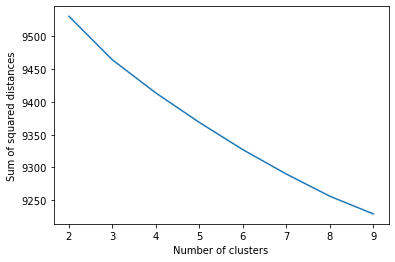

In [14]:
# find optimal K using elbow method
sse = []
k_list = list(range(2,10))

for k in k_list:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=2000, random_state=5)
    km.fit(text_features)
    sse.append(km.inertia_)
    
plt.figure()
plt.plot(k_list, sse)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

* Silhouette scores seem to improve from 5 clusters and above (with exception of k = 2)
* Optimal K from elbow method non-conclusive, no long tail present
* Can try to perform clustering on title as well
* Based on understanding of the reports, seems like there may be around 5 main topics, hence to try k = 5

In [15]:
# run KM with k = 5
km5 = KMeans(n_clusters=5, init='k-means++', max_iter=2000, random_state=5)
km5.fit(text_features)
    
print("Coefficient for 5 clusters: %0.3f" % metrics.silhouette_score(text_features, km5.labels_))

labels, counts = np.unique(km5.labels_[km5.labels_>=0], return_counts=True)
print(labels)
print(counts)

Coefficient for 5 clusters: 0.029
[0 1 2 3 4]
[ 979 1453  217  903 6448]


In [16]:
# print top terms for each cluster
def print_terms(cm, num, term):
    original_space_centroids = cm.cluster_centers_
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :term]:
            print(' %s' % terms[ind], end='')
        print()

print_terms(km5, 5, 15)

Cluster 0: truck crane trailer driver boom load side dump struck vehicle bed killed cab rear fell
Cluster 1: machine finger hand press right left amputated caught conveyor blade index number belt amputation saw
Cluster 2: datesicestablishment inspectionopen name zone excess except excavator excavation examiner examined examination evidence exchanger eventually event
Cluster 3: line power electrical electrocuted energized pole electric volt contacted shock conductor overhead phase burn meter
Cluster 4: fell ft foot floor injury ladder died tank killed struck two fire transported area 2013


Based on the above, Cluster 2 does not seem to be very informative. 4 clusters may be more relevant.

### Step 3: LDA model to identify topics
* A topic modelling approach like LDA can also be used to draw out main topics from the sea of unstructured text

In [17]:
# preprocess data for DTM
stopword = stopwords.words('english')+['employee','worker','wa','working','coworker','operator',\
                                       'approximately','a.m.','p.m.','employer','medical',\
                                      'hospital','hospitalized','center']
#snowball = SnowballStemmer('english')
lemma = nltk.WordNetLemmatizer()

def preproc3(tt):
    token = nltk.word_tokenize(tt.lower())
    token = [lemma.lemmatize(t) for t in token]
    token = [t for t in token if t not in stopword]
    token = [t for t in token if t not in string.punctuation+"'"""]
    return token

text3 = df['text']
text_clean3 = text3.apply(preproc3)

In [18]:
# construct DTM
import gensim 
from gensim import corpora

dictionary = corpora.Dictionary(text_clean3)
#print(dictionary)
dictionary.filter_extremes(no_below=2, no_above=0.8)
dtm = [dictionary.doc2bow(d) for d in text_clean3]

Initially, number of topics was set as 5 based on observation from K-means clustering. However, we noticed that 2 topics overlapped quite significantly and hence number of topics was eventually set as 4.

In [19]:
# apply LDA model
lda = gensim.models.ldamodel.LdaModel(dtm, num_topics = 4, id2word = dictionary, passes=10, chunksize=128, random_state=10)
lda.show_topics(10)

[(0,
  '0.010*"day" + 0.009*"ladder" + 0.009*"floor" + 0.009*"transported" + 0.008*"\'s" + 0.008*"fell" + 0.008*"work" + 0.007*"building" + 0.007*"foot" + 0.006*"roof"'),
 (1,
  '0.013*"burn" + 0.011*"tank" + 0.011*"water" + 0.010*"line" + 0.009*"2" + 0.009*"hot" + 0.007*"fire" + 0.007*"power" + 0.006*"gas" + 0.005*"degree"'),
 (2,
  '0.026*"machine" + 0.022*"hand" + 0.017*"right" + 0.017*"finger" + 0.016*"left" + 0.012*"\'s" + 0.011*"press" + 0.009*"number" + 0.008*"caught" + 0.006*"metal"'),
 (3,
  '0.017*"truck" + 0.011*"car" + 0.010*"struck" + 0.008*"line" + 0.008*"ground" + 0.007*"side" + 0.007*"train" + 0.007*"foot" + 0.007*"fell" + 0.007*"locomotive"')]

In [20]:
# evaluate coherence score of LDA model
## c_umass: conditional logistic probability of doc occurrence
## c_v: NPMI + cosine similarity
from gensim.models.coherencemodel import CoherenceModel

cm_umass = CoherenceModel(lda,  dictionary=dictionary, corpus=dtm, coherence='u_mass')
cm_cv = CoherenceModel(lda,  dictionary=dictionary, texts=text_clean3, coherence='c_v')
lda_umass = cm_umass.get_coherence()
lda_cv = cm_cv.get_coherence()
print("C_umass score: ",lda_umass) # C_umass: closer to zero the better
print("C_v score: ",lda_cv) # C_v: closer to 1 the better

C_umass score:  -2.1902406296524224
C_v score:  0.445116311488268


In [21]:
# visualise LDA model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda, dtm, dictionary)
pyLDAvis.display(LDAvis_prepared)

A lambda value of 0.6 appears to be effective in picking out the top relevant terms for each topic.

#### Question 1: What are the major types of accidents reflected in the reports?

Based on the 4 topics, the main themes identified are:
* Cluster 0: Fall-related accidents e.g. fall from roof
* Cluster 1: Fire/electric/gas related accidents e.g. explosions, flash fires
* Cluster 2: Machine-related accidents e.g. cuts, amputations
* Cluster 3: Vehicular accidents e.g. forklift, truck

In [22]:
# add labels to topics based on observation
dict = {0: 'fall', 1: 'fire', 2: 'machine', 3: 'vehicle'}

# get topic distribution of documents
doc_topics = lda.get_document_topics(dtm)

from operator import itemgetter
# show the topic distributions for the first 10 docs
for i in range(0, 10):
    print(doc_topics[i])
    print(max(doc_topics[i], key=itemgetter(1))[0])

[(0, 0.26335874), (1, 0.3349959), (3, 0.3989527)]
3
[(0, 0.22765592), (3, 0.7533047)]
3
[(0, 0.4375805), (2, 0.035577316), (3, 0.52227616)]
3
[(0, 0.13666488), (1, 0.14301474), (2, 0.20729439), (3, 0.513026)]
3
[(0, 0.08884344), (1, 0.6412622), (2, 0.07818504), (3, 0.19170932)]
1
[(0, 0.45756027), (1, 0.41209266), (2, 0.12301386)]
0
[(0, 0.101972364), (1, 0.18397532), (2, 0.52656305), (3, 0.18748923)]
2
[(0, 0.39974663), (2, 0.038795847), (3, 0.55600595)]
3
[(0, 0.3562691), (3, 0.624617)]
3
[(0, 0.8678843), (3, 0.11545771)]
0


C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here, we can see that for some documents e.g. index 0 and 5, there isn't a very clear and distinct category that stands out based on the probability distribution. This highlights the possibility of using other soft classification methods to explore if certain documents could have multiple topic labels. 

In [23]:
# select the best topic (with highest score) for each document
top_topic = [max(t, key=itemgetter(1))[0] for t in doc_topics]
#print(top_topic)

topics_perDoc = [dict[t] for t in top_topic]
#print(topics_perDoc)

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# count freq of each topic
print("\033[1m"+"Question 2: Which type of accidents has the largest number of occurrences?"+"\033[0m")
print("")
print("Number of reports involving falls: ",topics_perDoc.count('fall'))
print("Number of reports involving fire/electric/gas: ",topics_perDoc.count('fire'))
print("Number of reports involving machines/cuts: ",topics_perDoc.count('machine'))
print("Number of reports involving vehicles: ",topics_perDoc.count('vehicle'))
print("Total number of reports: ",len(topics_perDoc))

Question 2: Which type of accidents has the largest number of occurrences?

Number of reports involving falls:  3019
Number of reports involving fire/electric/gas:  2117
Number of reports involving machines/cuts:  1747
Number of reports involving vehicles:  3117
Total number of reports:  10000


C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can see that accidents involving vehicular-related events have the largest number of occurrences, with incidents involving falls following closely behind. 

In [25]:
# add topic category back to dataframe
df['topic'] = topics_perDoc
pd.set_option("display.max_colwidth", -1)
df.head(6)

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,title,text,title_count,text_count,topic
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2013 Employee #1 with Edco Waste & Recycling Services was operating a forklift (Linde Lift Truck; Serial Number: H2X393S04578; identified by the employer as FL-3) from approximately 4:00 a.m. moving bales of recyclable paper products from a collection area in the yard into trucks. Then Employee #1 cleaned and was replacing an air filter on the forklift FL-3. To clean out the air filter Employee #1 parked FL-3 in the doorway of the maintenance building. The air filter was located on the rear of the forklift behind the cab frame on the driver's side. Employee #1 removed the air filter and cleaned it out and then he climbed up onto the back of the forklift to replace it. While up on the back of the forklift Employee #1's foot dislodged the cooling system radiator cap. The fluid in the lift truck's cooling system was hot and under pressure from being operated all morning. The hot fluid sprayed up and out of the reservoir. Employee #1 was burned on the upper legs and the groin area. Employee #1 jumped off of the back of the forklift onto the ground. Coworkers came to his assistance and called emergency services. Employee #1 was hospitalized at a burn center for over 24 hours for treatment of second degree burns to the upper legs and groin area.,7,229,vehicle
1,202561825,Employee Falls From Flatbed Trailer And Later Dies,On August 30 2013 Employee #1 was working from a flatbed trailer. As he worked he fell from the flatbed trailer onto the ground striking his abdomen. The fall height of the flatbed trailer was 57 inches. Employee #1 sustained unspecified injuries in the fall that later on caused his death.,8,51,vehicle
2,200361855,Two Workers Are Struck By Motor Vehicle And One Is Killed,On August 27 2013 Employees #1 and #2 of Templar Inc. a construction company specializing in fiber optic installation and services were working along a highway. The highway speed limit was posted at 55 miles per hour. Employee #1 was marking the location of an underground line that ran below the turn lane. Employee #2 was next to Employee #1 and performing the duties of a flagger. A privately owned vehicle was travelling in the travel/through lane. The vehicle veered to the right entered the turn lane and struck both workers. Emergency medical services were called. Employee #1 was declared dead at the scene. Employee #2 refused emergency medical treatment for the bruises he received when struck.,11,117,vehicle
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iron and Metal Company Inc. was using a forklift (Hyster 50 sit down rider) to move and stack bundled cubes of recycled insulated co-axial (coax) cable and insulated copper wire. The cubes weighed anywhere from 1 000 to 2 000 lbs. Employee #1 had completed stacking one column consisting of five cubes in height along the northeast wall of the recycling warehouse. Employee #1 was beginning a new second column directly in front of the existing first column. Employee #1 placed the first cube of the second column tight against the bottom cube of the existing first column. Employee #1 then backed the forklift up approximately 5 ft and exited the forklift. Employee #1 then stepped in between the forklift and the cubes to either clean off the top from possible loose wires that created a hump or to place 4 ft by 4 ft dunnage so the next cube could be stacked. The five tier stack of cubes began to overturn. The first one went over Employee #1's head and settled on the forks. The second cube (weighing 1 948 lbs) struck Employee #1 on the left side of his face and upper torso and forced him back and down. Employee #1 was pinned between the first cube that fell and second cube. A third cube also fell which struck Employee #1's legs. Employee #1 received a puncture wound to the right abdomen area which caused increased

If we look at the probability distribution across topics for index 0 and 5 again:

Index 0: [('fall', 0.26335874), ('fire', 0.3349959), ('vehicle', 0.3989527)]; model prediction: 'vehicle'
* Here we see that the prediction probabilities of 'fire' and 'vehicle' are quite close, which corroborates with the report as the employee was burned by the radiator fluid within the forklift. There are multiple terms suggested both the topics of fire/gas/electric and vehicle related incidents.

Index 5: [('fall', 0.45756027), ('fire', 0.41209266), ('machine', 0.12301386)]; model prediction: 'fall'
* This is a rather unique entry. The text report does not seem to have any indication of a fall or have terms related to falls, yet the model predicted it to be within the fall-related incidents category. 'fire' was rather close behind, and it was understandable why as there were terms such as 'burns' and 'heat'.

In [26]:
# save LDA model
from gensim.test.utils import datapath

temp_file = datapath("LDA_model")
lda.save(temp_file)

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Step 4: Extract concept of body parts and occupation from the accident reports

In [27]:
# review some examples of accident reports to see if body parts or occupations are mentioned
pd.set_option("display.max_colwidth", -1)
df['text'].head(3)

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     At approximately 11:30 a.m. on November 13  2013  Employee #1  with Edco Waste  & Recycling Services  was operating a forklift (Linde Lift Truck; Serial  Number: H2X393S04578; identified by the employer as FL-3) from approximately  4:00 a.m.  moving bales of recyclable paper products from a collection area in  the yard into trucks. Then  Employee #1 cleaned and was replacing an air  filter on the forklift FL-3. To clean out the air filter  Employee #1 parked  FL-3 in the doorway of the maintenance building. The air filter was located on  the rear of the forklift  behind the cab frame on the driver's side. Employee  #1 removed the air filter and cleaned it out  and then he climbed up onto the  back of the forklift to replace it. While up on the back of the forklift   Employee #1's foot dislodged the cooling system radiator cap. The fluid in the  lift truck's cooling system was hot and under pressure from being operated all  morning. The hot fluid sprayed up and out of the reservoi

In [28]:
# import WordNet as a lexical resource
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')
nltk.download('wordnet')

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\desmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\desmo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\desmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Dictionary of body parts

In [29]:
# use hyponymy of suitable parent word to define dictionary of body parts
# using 'hand' as an example on http://wordnetweb.princeton.edu/, explore inherited hypernyms -- "body part" seems reasonable
ss1 = wn.synsets('body_part')[0]
print(ss1)

Synset('body_part.n.01')


C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# view all hyponyms of "body part"
ss1.hyponyms()

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Synset('abdomen.n.01'),
 Synset('adnexa.n.01'),
 Synset('ambulacrum.n.01'),
 Synset('ampulla.n.01'),
 Synset('apparatus.n.02'),
 Synset('area.n.03'),
 Synset('back.n.01'),
 Synset('buttock.n.01'),
 Synset('buttocks.n.01'),
 Synset('cannon.n.05'),
 Synset('dilator.n.01'),
 Synset('dock.n.06'),
 Synset('dorsum.n.02'),
 Synset('energid.n.01'),
 Synset('external_body_part.n.01'),
 Synset('feature.n.02'),
 Synset('flank.n.04'),
 Synset('fornix.n.01'),
 Synset('gaskin.n.01'),
 Synset('groove.n.03'),
 Synset('haunch.n.01'),
 Synset('hindquarters.n.02'),
 Synset('hip.n.01'),
 Synset('horseback.n.01'),
 Synset('joint.n.01'),
 Synset('lobe.n.01'),
 Synset('loin.n.02'),
 Synset('loins.n.02'),
 Synset('mentum.n.03'),
 Synset('organ.n.01'),
 Synset('partition.n.03'),
 Synset('process.n.05'),
 Synset('rectum.n.01'),
 Synset('rudiment.n.02'),
 Synset('saddle.n.06'),
 Synset('shank.n.02'),
 Synset('shin.n.01'),
 Synset('shoulder.n.01'),
 Synset('small.n.01'),
 Synset('structure.n.04'),
 Synset('stump

In [31]:
# save all body part words as a list
body = list(set(
                [b.replace('_', ' ').lower() for s in ss1.closure(lambda s:s.hyponyms())
                        for b in s.lemma_names()]))
print("Number of words: ",len(body))
sorted(body[:20])

Number of words:  3104


C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['arachnoid membrane',
 'articulator',
 'brachial artery',
 'brow',
 'capsula glomeruli',
 'cardinal vein',
 'cingulum',
 'corticospinal tract',
 'endometrium',
 'flexor',
 'imperforate hymen',
 'inner ear',
 'musculus sphincter ani externus',
 'neck',
 'onyxis',
 'pectoral fin',
 'prosencephalon',
 'purkinje fiber',
 'sphincter',
 'truncus celiacus']

#### Dictionary of occupations

In [32]:
# use hyponymy of suitable parent word to define dictionary of occupations
# using 'driver' as an example on http://wordnetweb.princeton.edu/, explore inherited hypernyms -- "worker" seems reasonable
ss2 = wn.synsets('worker')[0]
print(ss2)

Synset('worker.n.01')


C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# view all hyponyms of "worker"
ss2.hyponyms()

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Synset('assistant.n.01'),
 Synset('beater.n.01'),
 Synset('bill_poster.n.01'),
 Synset('bleacher.n.01'),
 Synset('boatman.n.01'),
 Synset('carter.n.03'),
 Synset('caster.n.01'),
 Synset('charcoal_burner.n.01'),
 Synset('collector.n.02'),
 Synset('comber.n.01'),
 Synset('cornhusker.n.01'),
 Synset('driver.n.02'),
 Synset('employable.n.01'),
 Synset('employee.n.01'),
 Synset('finisher.n.04'),
 Synset('freelancer.n.01'),
 Synset('gutter.n.03'),
 Synset('hanger.n.01'),
 Synset('lamplighter.n.01'),
 Synset('melter.n.01'),
 Synset('moonlighter.n.01'),
 Synset('mopper.n.01'),
 Synset('muzzler.n.01'),
 Synset('nailer.n.01'),
 Synset('oiler.n.01'),
 Synset('part-timer.n.01'),
 Synset('peeler.n.02'),
 Synset('planter.n.02'),
 Synset('plier.n.01'),
 Synset('processor.n.02'),
 Synset('pruner.n.01'),
 Synset('puller.n.02'),
 Synset('quarryman.n.01'),
 Synset('ragsorter.n.01'),
 Synset('scab.n.01'),
 Synset('scrubber.n.01'),
 Synset('seasonal_worker.n.01'),
 Synset('servant.n.01'),
 Synset('sheller

In [34]:
# save all worker words as a list
worker = list(set(
                [w.replace('_', ' ').lower() for s in ss2.closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))
print("Number of words: ",len(worker))
sorted(worker[:20])

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of words:  1415


['barrel maker',
 'black and tan',
 'decoy',
 "dressmaker's model",
 'funeral undertaker',
 'gofer',
 'hotel clerk',
 'lieutenant commander',
 'maid',
 'mechanic',
 'pensionary',
 'rear admiral',
 'roundsman',
 'sandwichman',
 'searcher',
 'section hand',
 'tanner',
 'tier',
 'unknown soldier',
 'warehouser']

#### Extract all nouns from report text and get frequencies

In [35]:
# extract all nouns from report text
pd.set_option("display.max_colwidth", 50)
lemma = nltk.WordNetLemmatizer()

def preproc4(tt):
    wpos = pos_tag(word_tokenize(tt))
    lemmas = []
    for w, pos in wpos:
        if pos in {'NN','NNS'}:
            lemmas.append(lemma.lemmatize(w.lower(), pos = 'n'))
    return lemmas

text4 = df['text']
text4_n = text4.apply(preproc4)
text4 = [t for t in text4]
text4_n

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       [forklift, employer, bale, paper, product, col...
1       [trailer, trailer, ground, abdomen, fall, heig...
2       [construction, company, installation, service,...
3       [forklift, rider, cube, coax, cable, copper, w...
4       [vacuum, truck, driver, operator, water, power...
                              ...                        
9995    [rail, car, metal, shop, control, box, waist, ...
9996    [p.m., steam, locomotive, resort, train, block...
9997    [remote, rail, engine, metal, submarine, car, ...
9998    [fireman, engineer, cab, steam, locomotive, ra...
9999    [p.m., contract, worker, refinery, shift, way,...
Name: text, Length: 10000, dtype: object

In [36]:
# flatten unique list and obtain freq distributions
text4_set = [list(set(f)) for f in text4_n]
text4_flat = [w for t in text4_set for w in t]

fd_n = FreqDist(text4_flat)
fd_n.most_common(10)

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('employee', 3623),
 ('injury', 1986),
 ('p.m.', 1798),
 ('hospital', 1783),
 ('hand', 1672),
 ('a.m.', 1573),
 ('foot', 1563),
 ('day', 1543),
 ('area', 1504),
 ('coworker', 1457)]

In [37]:
# find all unique tokens matching body parts
body_tokens = [(w, fd_n[w]) for w in fd_n.keys() if w in body]
body_tokens = sorted(body_tokens, key=lambda x: x[1], reverse=True)
body_tokens[:10]

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('hand', 1672),
 ('foot', 1563),
 ('area', 1504),
 ('side', 1235),
 ('head', 1066),
 ('finger', 1016),
 ('arm', 804),
 ('leg', 748),
 ('system', 648),
 ('body', 600)]

#### 3. Which part of the human body is injured most?
The most common body parts involved in accidents are 'hand', 'foot', 'head' and 'finger'. Looks like typically the extremities are involved in such accidents. This information may be potentially useful for enhancing workplace safety measures such as better protective gear for hands and feet, and also the use of appropriate headgear for specific activities. 

In [38]:
# find all unique tokens matching occupations
worker_tokens = [(w, fd_n[w]) for w in fd_n.keys() if w in worker]
worker_tokens = sorted(worker_tokens, key=lambda x: x[1], reverse=True)
worker_tokens[:10]

C:\Users\desmo\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('employee', 3623),
 ('hand', 1672),
 ('driver', 423),
 ('laborer', 273),
 ('mechanic', 202),
 ('paramedic', 178),
 ('technician', 174),
 ('conductor', 174),
 ('help', 169),
 ('loader', 165)]

#### 4. What are the more risky occupations involved in such accidents?
The more risky occupations involved in such accidents are 'driver', 'laborer', 'mechanic', 'paramedic', 'technician', and 'conductor'. As expected, most of the occupations are related to manual labour except for 'paramedics'. The term 'paramedic' may have been picked up as the reports may have mentioned the first responders attending to the victims, and these paramedics may not have been involved in the accident in the first place. It's also important to note that there were many reports stating just 'employee', which is a generic term. It may be helpful to further deep dive into the occupations of these employees to explore if there are other job roles which were not identified.